### imports and general stuff

In [46]:
import Pkg
Pkg.activate("../../juliaccel.jl/")
using JuliAccel
using DifferentialEquations
using LaTeXStrings
using Plots
using Statistics
using ProgressBars
using Dates

  Activating project at `~/Polybox/ETH/ParticleAcceleratorModelling/juliaccel.jl`


# 1 Space charge map for continuous beam

### General Parameters

In [175]:
# using a proton
# Coupled differential equations:
# x=[x, x', x'']
# x[3] + kx(s)*x[1] - ϵx^2/x[1]^3 - K/(2(x[1]+y[1])) = 0
# y[3] + ky(s)*y[1] - ϵy^2/y[1]^3 - K/(2(x[1]+y[1])) = 0

# parameters;
I = 1.                    # A
ϵ₀ = 8.854e-12              # F/m
m₀ = 1.6726219e-27          # kg
c = 3e8                     # m/s
q = 1.60217662e-19          # C
I0 = 4*π*ϵ₀*m₀*c / q        # A
I0 = 31e6                   # A for protons
β = 0.9                   # CHOSEN!
γ = 1/(1-(β)^2)
println(γ)
K = 2*I/(I0 * β^3 * γ^3)

# ϵx = √(varx*varx_prime - covarx)
# ϵy = √(vary*vary_prime - covary)

# x = rms_x/2
# y = rms_y/2


5.263157894736843


6.07018009646444e-10

In [149]:

#### DifferentialEquations
function elContBeamDiffEq!(du, u, p, t)
    x_env, x_env_prime, x_env_double_prime, y_env, y_env_prime, y_env_double_prime = u
    kx, ky, ϵx, ϵy, K = p

    du[1] = x_env_prime
    du[2] = x_env_double_prime
    du[3] = -kx * x_env + ϵx^2 / x_env^3 + K / (2 * (x_env + y_env))
    du[4] = y_env_prime
    du[5] = y_env_double_prime
    du[6] = -ky * y_env + ϵy^2 / y_env^3 + K / (2 * (x_env + y_env))
end

function calculateEpsilonsAndRMS(Γ)
    x = Γ[1,:]
    xp = Γ[2,:]
    y = Γ[3,:]
    yp = Γ[4,:]

    rms_x = sqrt(mean(x .^ 2))
    rms_y = sqrt(mean(y .^ 2))

    mean_x2 = mean(x .^ 2)  # ⟨x²⟩
    mean_xp2 = mean(xp .^ 2)  # ⟨x'²⟩
    mean_x_xp = mean(x .* xp)  # ⟨xx'⟩
    mean_y2 = mean(y .^ 2)  # ⟨y²⟩
    mean_yp2 = mean(yp .^ 2)  # ⟨y'²⟩
    mean_y_yp = mean(y .* yp)  # ⟨y'⟩

    epsilon_x = sqrt(mean_x2 * mean_xp2 - mean_x_xp^2)
    epsilon_y = sqrt(mean_y2 * mean_yp2 - mean_y_yp^2)
    
    return rms_x, rms_y, epsilon_x, epsilon_y
end


calculateEpsilonsAndRMS (generic function with 1 method)

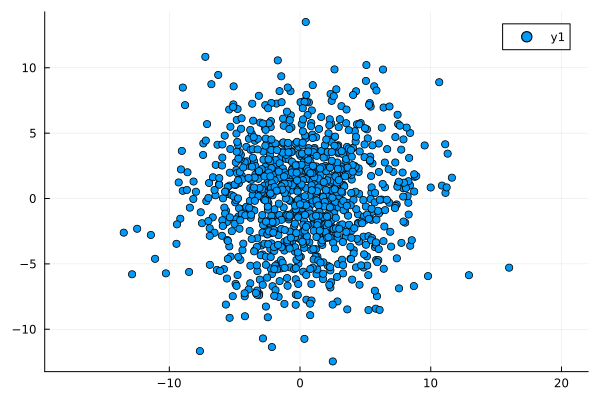

In [183]:
# generate particles
N_part = 1000 # number of particles

μ = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ = [16.0 0.0 0.0 0.0 0.0 0.0;
     0.0 1.0 0.0 0.0 0.0 0.0;
     0.0 0.0 16.0 0.0 0.0 0.0;
     0.0 0.0 0.0 1.0 0.0 0.0;
     0.0 0.0 0.0 0.0 0.709 0.0;
     0.0 0.0 0.0 0.0 0.0 0.0981]

D = Gaussian(μ, Σ)

Γi = gen_distribution(D, N_part)
plot(Γi[1,:], Γi[3,:], seriestype=:scatter, aspect_ratio=:equal)


### Try to solve ODE directly

(4.064680726939705, 3.8869414202710613, 4.007911639332361, 3.768194468940681)


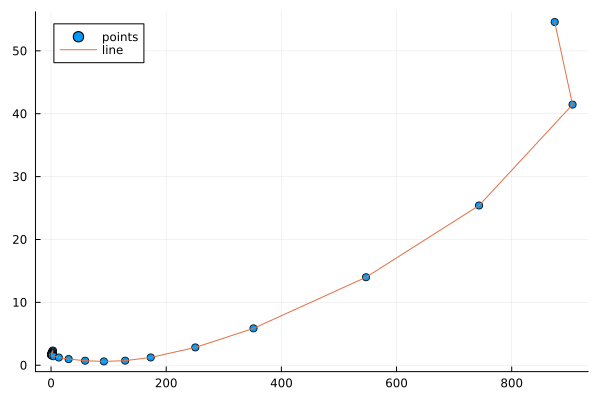

In [180]:
# SOLVE ODE DIRECTLY
Γi = gen_distribution(D, N_part)

rms_x, rms_y, ϵx, ϵy = calculateEpsilonsAndRMS(Γi)
println(calculateEpsilonsAndRMS(Γi))

# initial and general parameters
u0 = [rms_x/2, 0.01, 0.001, rms_y/2, 0.01, 0.001]
kx = 1.
ky = 1.
p = [kx, ky, ϵx, ϵy, K]

tspan = (0.0, 10.)
dt = 0.0001
prob = ODEProblem(elContBeamDiffEq!, u0, tspan, p)
# Solve the problem
sol = solve(prob, dt=dt)

x_values = sol[1, :]
y_values = sol[4, :]
# plot
plot(x_values, y_values, seriestype=:scatter, label="points")  # Plot x and y
plot!(x_values, y_values, label="line")  # Plot x and y

# THIS SOLUTION IS SUPER UNSTABLE


### Solve with Juliaccel Matrix

In [116]:
mad  = "pam-10.mad"
prob = "pam-10.japd"
n1 = 3
n2 = 6
n_max = n2 * (n1-1) + 1
pp = eval(:(@set_problem("x px y py z δ", $n1, $n2, $n_max)))

L = 0.1
kx = 1.
ky = 1.
K = 2*I/(I0 * β^3 * γ^3)
x_env = rms_x/2
y_env = rms_y/2
println(kx, " ", ky, " ", K, " ", x_env, " ", y_env)

# Ms  = gen_maps(mad, prob, symplectic=false)  ## THIS SHIT JUST DOESTNT WORK. DO EXPANSION MANUALLY
Ham_self = δ/β - sqrt((1/β+δ)^2 - px^2 - py^2 - 1/(β*γ)^2) + (K*(x^2 + y^2)/4(x_env^2 + y_env^2))
tps_expansion!(Ham_self)
Taylored_Ham_self = lie_transform(L*Ham_self, pp)
M_self = TaylorSeries.jacobian(Taylored_Ham_self)

1.0 1.0 6.07018009646444e-10 1.9699448940020392 1.9994130543411819


6×6 transpose(::Matrix{Float64}) with eltype Float64:
 1.0          -0.0916698  0.0           0.0        0.0   0.0
 3.85245e-12   1.0        0.0           0.0        0.0   0.0
 0.0           0.0        1.0          -0.0916698  0.0   0.0
 0.0           0.0        3.85245e-12   1.0        0.0   0.0
 0.0           0.0        0.0           0.0        1.0  -0.00343322
 0.0           0.0        0.0           0.0        0.0   1.0

### Propagate and Plot

[ Info: Saved animation to /home/jonas/Polybox/ETH/ParticleAcceleratorModelling/Exercises_PAM/Ex10/JuliaccelMatrix.gif


Plots.AnimatedGif("/home/jonas/Polybox/ETH/ParticleAcceleratorModelling/Exercises_PAM/Ex10/JuliaccelMatrix.gif")
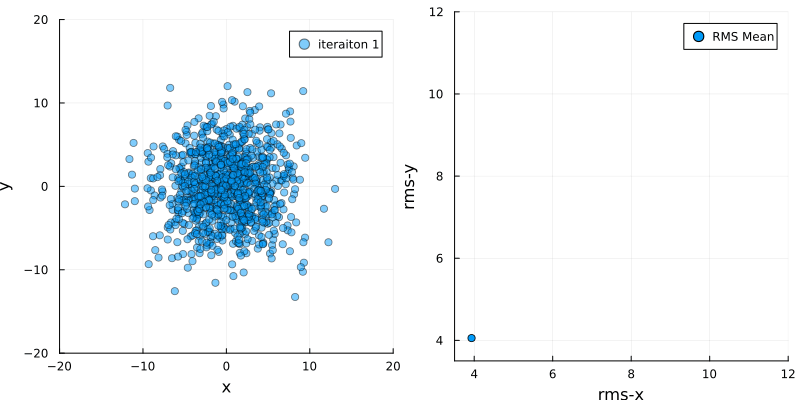

In [52]:
# propagate:
N_iterations = 100
Γ = Array{Float64, 3}(undef, N_iterations+1, 6, 1000)
rmsx_array = Array{Float64, 1}(undef, N_iterations+1)
rmsy_array = Array{Float64, 1}(undef, N_iterations+1)
Γ[1, :, :] = Γi  
for i ∈ 1:N_iterations
    rmsx_array[i] = sqrt(mean(Γ[i,1,:] .^ 2))
    rmsy_array[i] = sqrt(mean(Γ[i,3,:] .^ 2))
    Γ[i+1,:,:] = M_self * Γ[i,:,:]
end

# Plot
anim = @animate for i ∈ 1:N_iterations
    p1 = plot(Γ[i,1,:], Γ[i,3,:], seriestype=:scatter, alpha=0.5, aspect_ratio=:equal, xlabel = "x", ylabel="y", label="iteraiton "*string(i))
    xlims!(-20, 20)
    ylims!(-20, 20)

    p2 = plot(rmsx_array[1:i], rmsy_array[1:i], seriestype=:scatter, label="RMS Mean", xlabel="rms-x", ylabel="rms-y")
    xlims!(3.5, 12)
    ylims!(3.5, 12)
    
    plot(p1, p2, layout=(1, 2), size=(800, 400))
end

gif(anim, "JuliaccelMatrix.gif", fps = 15)

# Now in 3D